In [1]:
from matplotlib import pyplot as plt
import numpy as np
from cpymad.madx import Madx
import pandas as pd

# Tutorial 5


## First part
Building the sequence and making it thin. 

In [2]:
myMad = Madx()
myString='''
!! General parameters
Lcell = 100;
nBend=736;

!! Dipole Parameters
Ld = 15;
Ad = 2*pi/nBend;

!! Quadrupole Parameters
K1F = 5e-3;
K1D = -K1F;
Lq =5;

!! Sextupole Parameters
K2F = 0.0;
K2D = -K2F;
Ls = 0.5;
QF: QUADRUPOLE, L:=Lq, K1:=K1F;
QD: QUADRUPOLE, L:=Lq, K1:=K1D;
BM: SBEND, L=Ld, angle:=Ad;
SF: SEXTUPOLE, L:=Ls, K2:=K2F;
SD: SEXTUPOLE, L:=Ls, K2:=K2D;

JUAS: SEQUENCE, REFER=center, L=100; !it is important to refer to the the center this time, to make it compatible with the makethin 
qf: QF, at=0+QF->L/2;
S1 : SF, at=5+SF->L/2;
b1:  BM, at=10+BM->L/2;
b2:  BM, at=30+BM->L/2;
qd: QD, at=50+QD->L/2;
S2 : SD, at=55+SD->L/2;
b3:  BM, at=60+BM->L/2;
b4:  BM, at=80+BM->L/2;
ENDSEQUENCE;

beam, particle=proton, energy=7000;
use, sequence=JUAS;
twiss, table= thick_sequence;

MAKETHIN, SEQUENCE=JUAS;
use, sequence=JUAS;
twiss, table= thin_sequence;
'''
myMad.input(myString);


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.01.21 21:21:13      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
               100                 -0    0.0007669724505        36.10855572 

                q1                dq1            betxmax              dxmax 
      0.2064690988       -0.240670538        159.7689581        2.989009703 

             dxrms             xcomax             xcorms                 q2 
       2.434308282                  0                  0       0.2063310524 

               dq2            betymax              dymax              dyrms 
     -0.2407924343        159.8534466                  0                  0 

            ycomax             ycorms             deltap 

Comparing the thick and thin sequence.

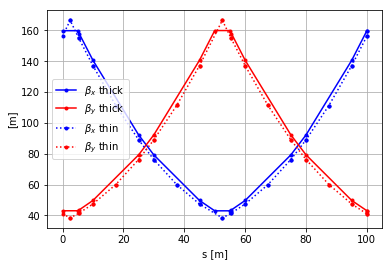

In [3]:
thickDF=myMad.table['thick_sequence'].dframe()
thinDF=myMad.table['thin_sequence'].dframe()

plt.plot(thickDF['s'],thickDF['betx'],'.-b',label='$\\beta_x$ thick')
plt.plot(thickDF['s'],thickDF['bety'],'.-r',label='$\\beta_y$ thick')
plt.plot(thinDF['s'],thinDF['betx'],'.:b',label='$\\beta_x$ thin')
plt.plot(thinDF['s'],thinDF['bety'],'.:r',label='$\\beta_y$ thin')
plt.xlabel('s [m]')
plt.ylabel('[m]')
plt.grid()
plt.legend()

### Matching the tunes

In [4]:
myString='''
//*************************************************//
!   MATCHING OF THE TUNES
//*************************************************//
use, sequence=JUAS;

match, sequence=JUAS;
!! Variables
vary,name=K1F,step=0.0001;
vary,name=K1D,step=0.0001;
!! Constraints
global, Q1=0.25;
global, Q2=0.25;
!! The next line ask MAD-X to do the matching itself
LMDIF, calls = 1000, tolerance=1E-12;
endmatch;
twiss, table=thin_new_wp;
value, beam->beta;
'''
myMad.input(myString);

START MATCHING

number of sequences: 1
sequence name: juas
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   3.19237631e-19





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
k1f                       5.65500e-03  5.00000e-03 -1.00000e+20  1.00000e+20
k1d                      -5.65654e-03 -5.00000e-03 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   3.19237631e-19
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
               100                 -0    0.0005392861793        43.06161907 

                q1       

### Chromaticity
We could assume ultra-relativistic beam.

In [5]:
myMad.sequence['JUAS'].beam.beta

0.9999999910167906

In [6]:
dq1_ref=myMad.table['summ'].dq1[0]

In [7]:
dq1_ref*myMad.sequence['JUAS'].beam.beta*1e-3

-0.0003181838661461889

This detuning is quite important.

### Tracking

In [8]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//
track,dump,file='./firstpart/linear_machine', DELTAP=0.00;
start, x= 1e-3, px=0, y= 1e-3, py=0;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;
!plot, file="linear_machine",table=track,haxis=x,vaxis=px,
!particle=1,2, colour=100;
!plot, file="linear_machine",table=track,haxis=y,vaxis=py,
!particle=1,2, colour=100;
'''
myMad.input(myString);

enter TRACK module

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0              0.001                  0 
         2          0                0.1                  0 
         1        100    0.0009999993875   -1.058506078e-11 
         2        100      0.09944526157   -9.581926561e-06 

                 y                 py                  t                 pt 
             0.001                  0                  0                  0 
               0.1                  0                  0                  0 
    0.001000000136   -1.059229822e-11   -7.993773682e-06                  0 
      0.1001230044   -9.589510844e-06      -0.0799449324                  0 

                 s                  e 
                 0                  0 
                 0                  0 
               100                  0 
               100                  0 
exit TRACK module



In [9]:
linear_particle_1=myMad.table['track.obs0001.p0001'].dframe()
linear_particle_2=myMad.table['track.obs0001.p0002'].dframe()

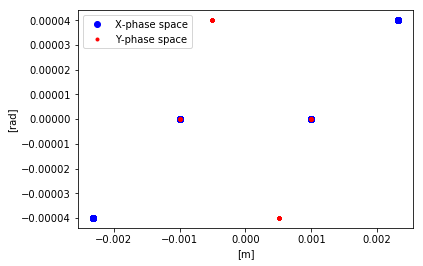

In [10]:
myParticle=linear_particle_1
plt.plot(myParticle['x'],myParticle['px'],'ob',label='X-phase space')
plt.plot(myParticle['y'],myParticle['px'],'.r',label='Y-phase space')
#plt.plot(linearDF.iloc[1].TABLE['X'],linearDF.iloc[1].TABLE['PX'],'ob')
#plt.plot(linearDF.iloc[1].TABLE['Y'],linearDF.iloc[1].TABLE['PY'],'.r')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

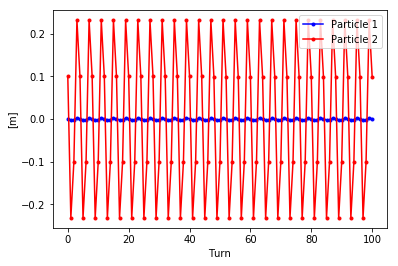

In [11]:
plt.plot(linear_particle_1['turn'],linear_particle_1['x'],'.-b', label='Particle 1')
plt.plot(linear_particle_2['turn'],linear_particle_2['x'],'.-r', label='Particle 2')
plt.xlabel('Turn')
plt.ylabel('[m]');
plt.legend(loc='best');

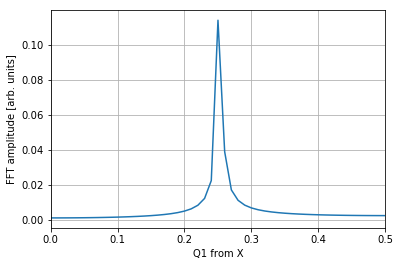

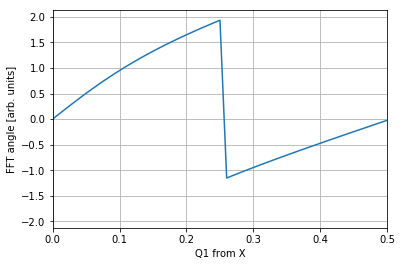

In [12]:
# Just play with an FFT on 
plt.figure()
plt.plot(np.linspace(0,1,len(linear_particle_1['x'])), np.abs(np.fft.fft(linear_particle_1['x'])))
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]');
plt.xlim(0,0.5)
plt.grid()
plt.figure()
plt.plot(np.linspace(0,1,len(linear_particle_1['x'])), np.angle(np.fft.fft(linear_particle_1['x'])))
plt.xlabel('Q1 from X')
plt.ylabel('FFT angle [arb. units]');
plt.xlim(0,0.5)
plt.grid()

### Track off-momentum

In [13]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//
track,dump,file='./firstpart/linear_machine_off_energy', DELTAP=0.01;
start, x= 1e-3, px=0, y= 1e-3, py=0;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;
!plot, file="linear_machine",table=track,haxis=x,vaxis=px,
!particle=1,2, colour=100;
!plot, file="linear_machine",table=track,haxis=y,vaxis=py,
!particle=1,2, colour=100;
'''
myMad.input(myString);

enter TRACK module
track_deltap:               0.01

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0              0.001                  0 
         2          0                0.1                  0 
         1        100     0.002184585878     4.78467653e-05 
         2        100       0.1722725307     0.003662175449 

                 y                 py                  t                 pt 
             0.001                  0                  0     0.009999999911 
               0.1                  0                  0     0.009999999911 
  -0.0008660042344    3.648792955e-05     -0.05480573899     0.009999999911 
    -0.08643634669     0.003652297671      -0.1263963579     0.009999999911 

                 s                  e 
                 0                  0 
                 0                  0 
               100                  0 
               100                  0 
exit TRACK module



In [14]:
off_momentum_linear_particle_1=myMad.table['track.obs0001.p0001'].dframe()
off_momentum_linear_particle_2=myMad.table['track.obs0001.p0002'].dframe()

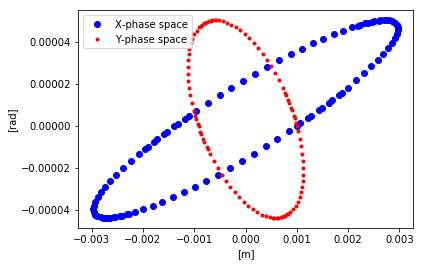

In [15]:
myParticle=off_momentum_linear_particle_1
plt.plot(myParticle['x'],myParticle['px'],'ob',label='X-phase space')
plt.plot(myParticle['y'],myParticle['px'],'.r',label='Y-phase space')
#plt.plot(linearDF.iloc[1].TABLE['X'],linearDF.iloc[1].TABLE['PX'],'ob')
#plt.plot(linearDF.iloc[1].TABLE['Y'],linearDF.iloc[1].TABLE['PY'],'.r')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

(0, 0.5)

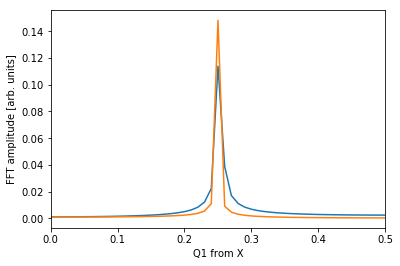

In [16]:
plt.plot(np.linspace(0,1,len(linear_particle_1['x'])), np.abs(np.fft.fft(linear_particle_1['x'])))
plt.plot(np.linspace(0,1,len(off_momentum_linear_particle_1['x'])), np.abs(np.fft.fft(off_momentum_linear_particle_1['x'])))
plt.xlim(0,.5)
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]');
plt.xlim(0,0.5)

**Conclusions**: the tune changed due to chromaticity.

## Second part
### Matching of the chromaticity

In [17]:
myString='''
//*************************************************//
!   MATCHING OF THE CHROMATICITY
//*************************************************//
match, sequence=JUAS;
!!! Variables
vary,name=K2F,step=0.0001;
vary,name=K2D,step=0.0001;
!!! Constraints
global, dq1=0.0;
global, dq2=0.0;
!!! The next line ask MAD-X to do the matching itself
LMDIF, calls = 1000, tolerance=1E-50;
endmatch;
'''
myMad.input(myString);

START MATCHING

number of sequences: 1
sequence name: juas
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   7.99283206e-32





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
k2f                       2.86196e-02  0.00000e+00 -1.00000e+20  1.00000e+20
k2d                      -5.54297e-02  0.00000e+00 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   7.99283206e-32


In [18]:
myString='''
//*************************************************//
!   TWISS
//*************************************************//
SELECT,FLAG=TWISS, column=name,s,betx,bety,dx,K1L,K2L;
twiss,file="./firstpart/tutorial5.txt";
!plot, HAXIS=s, VAXIS=betx,bety,dx,dy,colour=100, interpolate;
'''
myMad.input(myString);
thinZeroChromaDFTable=myMad.table['twiss'].dframe()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
               100                 -0    0.0005392861793        43.06161907 

                q1                dq1            betxmax              dxmax 
              0.25                 -0        170.6577821        2.310669633 

             dxrms             xcomax             xcorms                 q2 
       1.723324818                  0                  0               0.25 

               dq2            betymax              dymax              dyrms 
   2.827159717e-16        170.6875088                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            

In [19]:
thinNewWPDFTable=myMad.table['thin_new_wp'].dframe()

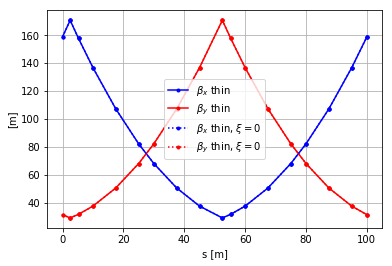

In [20]:
#thinNewWPDF=madx.tfs2pd('./firstpart/thinSequenceNewWP.txt')
#thinNewWPDFTable=thinNewWPDF.iloc[0].TABLE
plt.plot(thinNewWPDFTable['s'],thinNewWPDFTable['betx'],'.-b',label='$\\beta_x$ thin')
plt.plot(thinNewWPDFTable['s'],thinNewWPDFTable['bety'],'.-r',label='$\\beta_y$ thin')
plt.plot(thinZeroChromaDFTable['s'],thinZeroChromaDFTable['betx'],'.:b',label='$\\beta_x$ thin, $\\xi=0$')
plt.plot(thinZeroChromaDFTable['s'],thinZeroChromaDFTable['bety'],'.:r',label='$\\beta_y$ thin, $\\xi=0$')

plt.xlabel('s [m]')
plt.ylabel('[m]')
plt.grid()
plt.legend()

Chromaticity from the formulas.

In [21]:
thinZeroChromaDFTable[['name','s','betx','dx','k2l']]

name       s        betx        dx       k2l
#s           juas$start:1    0.00  158.844214  2.229002  0.000000
drift_0[0]      drift_0:0    2.50  170.657782  2.310670  0.000000
qf                   qf:1    2.50  170.657782  2.310670  0.000000
drift_1[0]      drift_1:0    5.25  157.690336  2.220835  0.000000
s1                   s1:1    5.25  157.690336  2.220835  0.014310
drift_2[0]      drift_2:0   10.00  136.715911  2.065666  0.000000
b1_den           b1_den:1   10.00  136.715911  2.065666  0.000000
drift_3[0]      drift_3:0   17.50  107.270538  1.820663  0.000000
b1                   b1:1   17.50  107.270538  1.820663  0.000000
drift_4[0]      drift_4:0   25.00   82.314836  1.639621  0.000000
b1_dex           b1_dex:1   25.00   82.314836  1.639621  0.000000
drift_5[0]      drift_5:0   30.00   68.176858  1.518926  0.000000
b2_den           b2_den:1   30.00   68.176858  1.518926  0.000000
drift_6[0]      drift_6:0   37.50   50.718624  1.337883  0.000000
b2                   b2:1   37.50   50.718624  1.337883  0.000000
drift_7[0]      drift_7:0   45.00   37.755728  1.220819  0.000000
b2_dex           b2_dex:1   45.00   37.755728  1.220819  0.000000
drift_8[0]      drift_8:0   52.50   29.292422  1.103755  0.000000
qd                   qd:1   52.50   29.292422  1.103755  0.000000
drift_9[0]      drift_9:0   55.25   31.873182  1.146678  0.000000
s2                   s2:1   55.25   31.873182  1.146678 -0.027715
drift_10[0]    drift_10:0   60.00   37.755728  1.220819  0.000000
b3_den           b3_den:1   60.00   37.755728  1.220819  0.000000
drift_11[0]    drift_11:0   67.50   50.718624  1.337883  0.000000
b3                   b3:1   67.50   50.718624  1.337883  0.000000
drift_12[0]    drift_12:0   75.00   68.176858  1.518926  0.000000
b3_dex           b3_dex:1   75.00   68.176858  1.518926  0.000000
drift_13[0]    drift_13:0   80.00   82.314836  1.639621  0.000000
b4_den           b4_den:1   80.00   82.314836  1.639621  0.000000
drift_14[0]    drift_14:0   87.50  107.270538  1.820663  0.000000
b4                   b4:1   87.50  107.270538  1.820663  0.000000
drift_15[0]    drift_15:0   95.00  136.715911  2.065666  0.000000
b4_dex           b4_dex:1   95.00  136.715911  2.065666  0.000000
drift_16[0]    drift_16:0  100.00  158.844214  2.229002  0.000000
#e             juas$end:1  100.00  158.844214  2.229002  0.000000

In [22]:
#aux=thinZeroChromaDFTable[(thinZeroChromaDFTable['name']=='s1:1') | (thinZeroChromaDFTable['name']=='s2:1')]
aux=thinZeroChromaDFTable
(aux['betx']*aux['dx']*1*aux['k2l']).sum()/4./np.pi

0.31818386900450124

In [23]:
dq1_ref

-0.3181838690045012

Very good compensation!

### Tracking after chromaticity

In [24]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//
track,dump,file='./firstpart/withSextupoles', DELTAP=0.01;
start, x= 1e-3, px=0, y= 1e-3, py=0;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;
!plot, file="MAD_track",table=track,haxis=x,vaxis=px,
!particle=1,2, colour=100;
!plot, file="MAD_track",table=track,haxis=y,vaxis=py,
!particle=1,2, colour=100;
'''
myMad.input(myString);

enter TRACK module
track_deltap:               0.01

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0              0.001                  0 
         2          0                0.1                  0 
         1        100    0.0009999737307    4.155530104e-09 
         2        100               -nan               -nan 

                 y                 py                  t                 pt 
             0.001                  0                  0     0.009999999911 
               0.1                  0                  0     0.009999999911 
    0.001004154925   -3.402017759e-07      -0.0542867101     0.009999999911 
              -nan               -nan               -nan     0.009999999911 

                 s                  e 
                 0                  0 
                 0                  0 
               100                  0 
               100                  0 
exit TRACK module



In [25]:
off_momentum_nonlinear_particle_1=myMad.table['track.obs0001.p0001'].dframe()
off_momentum_nonlinear_particle_2=myMad.table['track.obs0001.p0002'].dframe()

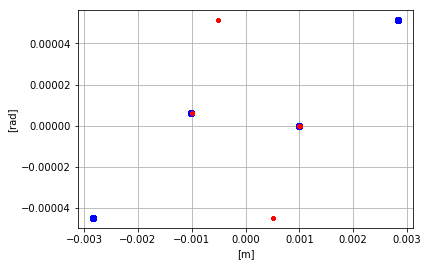

In [26]:
myParticle=off_momentum_nonlinear_particle_1
plt.plot(myParticle['x'],myParticle['px'],'ob',label='X-phase space')
plt.plot(myParticle['y'],myParticle['px'],'.r',label='Y-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.grid()

### But...
What is the cost of increasing the energy acceptance...? A decrease in transverse acceptance.

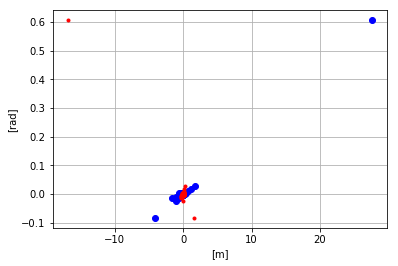

In [27]:
myParticle=off_momentum_nonlinear_particle_2
plt.plot(myParticle['x'],myParticle['px'],'ob',label='X-phase space')
plt.plot(myParticle['y'],myParticle['px'],'.r',label='Y-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.grid()

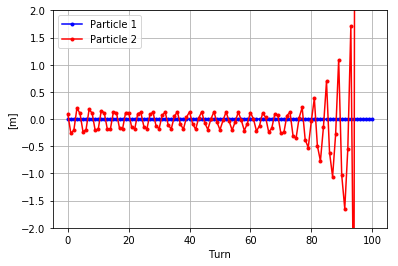

In [28]:
plt.plot(off_momentum_nonlinear_particle_1['turn'],off_momentum_nonlinear_particle_1['x'],'.-b', label='Particle 1')
plt.plot(off_momentum_nonlinear_particle_2['turn'],off_momentum_nonlinear_particle_2['x'],'.-r', label='Particle 2' )
plt.xlabel('Turn')
plt.ylabel('[m]');
plt.legend(loc='best');
plt.ylim(-2,2)
plt.grid()

### Matching the tunes at (0.23,0.23)

In [29]:
myString='''
//*************************************************//
!   MATCHING OF THE TUNES
//*************************************************//
use, sequence=JUAS;

match, sequence=JUAS;
!! Variables
vary,name=K1F,step=0.0001;
vary,name=K1D,step=0.0001;
!! Constraints
global, Q1=0.23;
global, Q2=0.23;
!! The next line ask MAD-X to do the matching itself
LMDIF, calls = 1000, tolerance=1E-12;
endmatch;
'''
myMad.input(myString);

START MATCHING

number of sequences: 1
sequence name: juas
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.24189067e-20





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
k1f                       5.28850e-03  5.65500e-03 -1.00000e+20  1.00000e+20
k1d                      -5.29009e-03 -5.65654e-03 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   1.24189067e-20


In [30]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//
track,dump,file='./firstpart/newWP', DELTAP=0.01;
start, x= 1e-3, px=0, y= 1e-3, py=0;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;
!plot, file="MAD_track",table=track,haxis=x,vaxis=px,
!particle=1,2, colour=100;
!plot, file="MAD_track",table=track,haxis=y,vaxis=py,
!particle=1,2, colour=100;
'''
myMad.input(myString);

enter TRACK module
track_deltap:               0.01

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0              0.001                  0 
         2          0                0.1                  0 
         1        100    9.855010261e-05   -1.358341186e-05 
         2        100      0.05307021096   -0.0006440131514 

                 y                 py                  t                 pt 
             0.001                  0                  0     0.009999999911 
               0.1                  0                  0     0.009999999911 
    0.001137349459    -1.69953615e-05     -0.06256532588     0.009999999911 
      0.1357501231    -0.001582726486      -0.0444163259     0.009999999911 

                 s                  e 
                 0                  0 
                 0                  0 
               100                  0 
               100                  0 
exit TRACK module



In [31]:
optWP_off_momentum_nonlinear_particle_1=myMad.table['track.obs0001.p0001'].dframe()
optWP_off_momentum_nonlinear_particle_2=myMad.table['track.obs0001.p0002'].dframe()

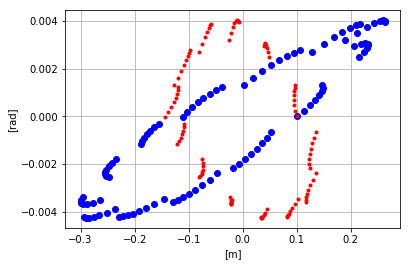

In [32]:
myParticle=optWP_off_momentum_nonlinear_particle_2
plt.plot(myParticle['x'],myParticle['px'],'ob',label='X-phase space')
plt.plot(myParticle['y'],myParticle['px'],'.r',label='Y-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.grid()